# DSCI 100 09 Group 09 Project Report: Stroke Diagnosis

Andrew Tran, David Wang, Elianna, Tosaki 

## 1. Introduction

Every day, children and adults around the world suffer from a medical condition known as a stroke. A stroke happens when  disruption occurs in the blood supply to the brain. Strokes can have serious and potentially life-threatening consequences, as they can lead to brain damage, disability, or even death. We explored *Kaggle* and chose a stroke data set that contained multiple categories that contribute to stroke. There are several factors that contribute to a person's chances of getting a stroke which include but are not limited to: blood pressure levels, BMI (Body Mass Index), smoking, physical activity, age, and more. Our project aims to predict the likelihood of someone getting a stroke based on their age and stress levels. We want to attempt to answer the following question: How does age and stress levels affect the risks of getting a stroke?

## 2. Methods and Results

In our data analysis, we want to visualize and investigate the relationship between age and stress levels, and if they have any impact on stroke diagnosis. Through this examination, we will create a classification model that will classify the diagnosis based on given observations.

Here we start off by opening the following packages: tidyverse, tidymodels and repr. Then we proceeded to install the *kknn* and *cowplot* packages. These packages allowed us to wrangle, classify, and visualize our code. Finally, we set seed to ensure that our data is reproducible.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
install.packages("kknn")
install.packages("cowplot")
set.seed(559)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [21]:
# We load in the data set from Kaggle

stroke <- read_csv("https://raw.githubusercontent.com/Megunight/dsci100-project/main/stroke_prediction_dataset.csv")

Rows: 15000 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): Patient Name, Gender, Marital Status, Work Type, Residence Type, S...
dbl  (8): Patient ID, Age, Hypertension, Heart Disease, Average Glucose Leve...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Step 1. Wrangle and Clean Data

First, we labelled the category names to make the columns easy to interpret and read.

In [3]:
# The columns were labelled as 'X1, X2, X3, etc.' Thus, we renamed the columns to accuractely represent categories.

names(stroke) <- c("patient_id", "patient_name", "age", "gender", "hypertension", "heart_disease", "marital_status",
                  "work_type", "residence_type", "average_glucose_level", "bmi", "smoking_status", "alcohol_intake", "physical_activity",
                  "stroke_history", "family_history_of_stroke", "dietary_habits", "stress_levels", "blood_pressure_levels",
                  "cholesterol_levels", "symptoms", "diagnosis")
head(stroke)

patient_id,patient_name,age,gender,hypertension,heart_disease,marital_status,work_type,residence_type,average_glucose_level,⋯,alcohol_intake,physical_activity,stroke_history,family_history_of_stroke,dietary_habits,stress_levels,blood_pressure_levels,cholesterol_levels,symptoms,diagnosis
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,⋯,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,⋯,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,⋯,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,⋯,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Headache, Confusion",No Stroke
48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,⋯,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke
29307,Advika Kota,62,Female,0,0,Single,Private,Urban,91.60,⋯,Social Drinker,High,0,No,Gluten-Free,4.85,132/64,"HDL: 80, LDL: 69",Severe Fatigue,Stroke


In [4]:
#3 different variables have been selected for use

stroke_selected <- stroke |>
                    select(age,
                           stress_levels,
                           diagnosis)

In [5]:
# The sample contained over 15,000 data points. 
# Therefore, we decided to take a random sample of 5000. 
# This would also ensure that our visualization doesn't become too overcrowded. 

stroke_sample <- stroke_selected |>
                sample_n(5000)

We start by splitting the data. Seventy-five percent of the data goes into our training set while the remaining twenty-five percent go towards the testing set. From this point onwards, we will only continue to work with the training set and leave the testing set aside.

In [22]:
# A summary table of our training set

stroke_split <- initial_split(stroke_sample, prop = 0.75, strata = diagnosis)
stroke_training <- training(stroke_split)
stroke_testing <- testing(stroke_split)

head(stroke_training, n = 10)

age,stress_levels,diagnosis
<dbl>,<dbl>,<chr>
76,2.20,No Stroke
84,9.91,No Stroke
31,2.20,No Stroke
74,2.07,No Stroke
47,2.27,No Stroke
33,5.98,No Stroke
36,0.21,No Stroke
55,6.55,No Stroke
22,7.77,No Stroke


#### Table 1. 

Table 1. shows a summary of our training set from the original data (of which 75% is put into the training). Upon examining the first ten rows in the summary table, it appears that age and stress levels have no correlation at all to diagnosing stroke. One could make this assumption since the age and stress level values are all over the place but the diagnosis column shows 'No Stroke' for all of them.

We wrangle our age and stress categories by grouping them. Age and class were classified into separate numerical categories to ensure that we could create a visualization that is feasible to work with. Had we not mutated it, there would have been an extremely overwhelming amount of data points/numbers on the visualization. 

Diagnosis needed to be turned into a factor from a character. This allows us to create a confusion matrix, since it only allows numerics.

In [27]:
stroke_training <- stroke_training |>
  mutate(stress_level_category = case_when(
    stress_levels <= 2.5 ~ "Low",
    stress_levels > 2.5 & stress_levels <= 5.0 ~ "Moderate",
    stress_levels > 5.0 & stress_levels <= 7.5 ~ "High",
    stress_levels > 7.5 ~ "Very High") )


stroke_training <- stroke_training |>
    mutate(age_group = cut(age, breaks = seq(0, 100, by = 10), labels = seq(0, 90, by = 10), right = FALSE)) 

stroke_testing <- stroke_testing |>
  mutate(stress_level_category = case_when(
    stress_levels <= 2.5 ~ "Low",
    stress_levels > 2.5 & stress_levels <= 5.0 ~ "Moderate",
    stress_levels > 5.0 & stress_levels <= 7.5 ~ "High",
    stress_levels > 7.5 ~ "Very High") )

stroke_testing <- stroke_testing |>
    mutate(age_group = cut(age, breaks = seq(0, 100, by = 10), labels = seq(0, 90, by = 10), right = FALSE)) 

stroke_training <- stroke_training |>
    mutate(diagnosis_group = fct_recode(diagnosis, "0" = "No Stroke", "1" = "Stroke"))

stroke_testing <- stroke_testing |>
    mutate(diagnosis_group = fct_recode(diagnosis, "0" = "No Stroke", "1" = "Stroke"))

In [8]:
# We create a small table to show the count of the diagnosis

stroke_obs <- stroke_training |>
                group_by(diagnosis) |>
                summarise(count = n())
stroke_obs

diagnosis,count
<chr>,<int>
No Stroke,1843
Stroke,1906


#### Table 2.

This table shows the count (number of) of people's stroke diagnosis. Analyzing it, we can see that there's a fairly even distribution between 'No Stroke' and 'Stroke.'

### Step 2. Visualization of Diagnosis

Next, we create two bar plots to represent the diagnosis depending on either people's ages or stress levels.

Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


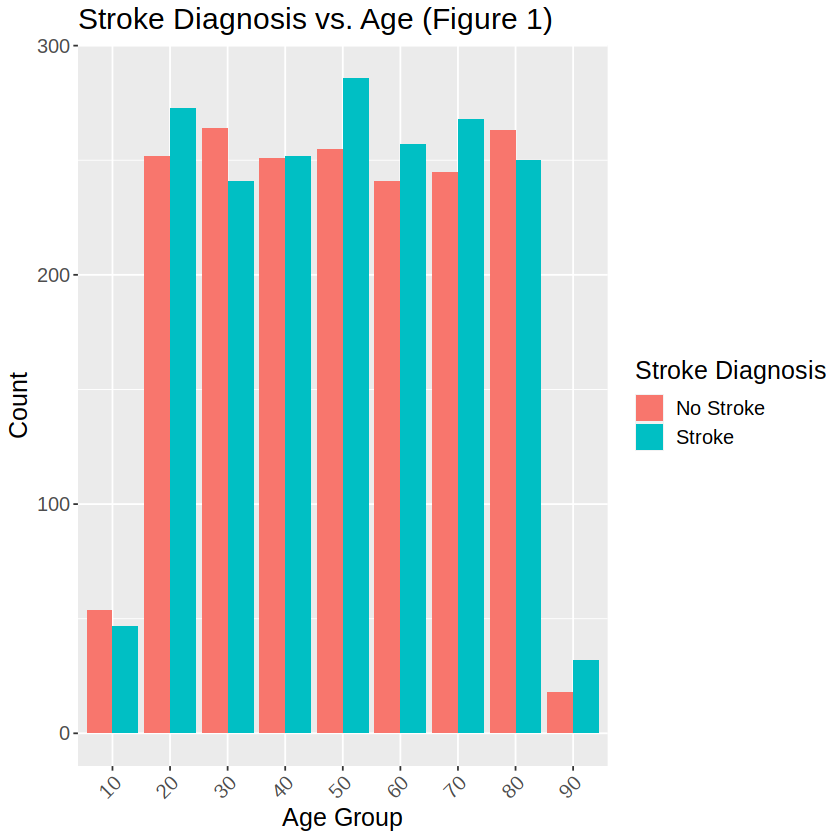

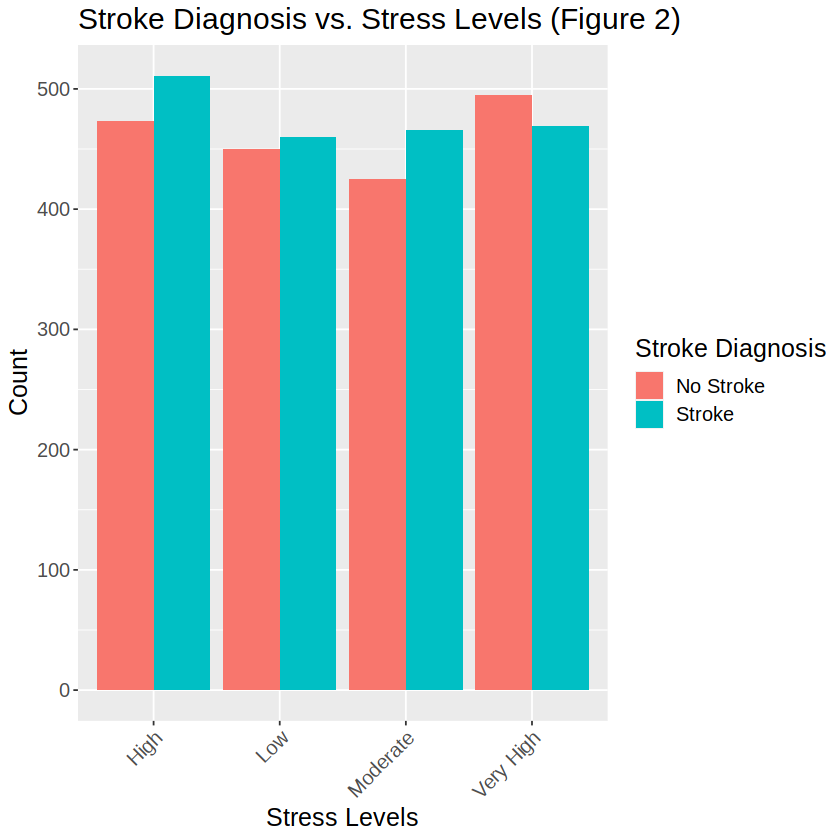

In [28]:
options(repr.plot.width = 7, repr.plot.height = 7)

stroke_age <- stroke_training |>
            ggplot(aes(x = age_group, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Age Group", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Age (Figure 1)") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_age

stroke_stress <- stroke_training |>
            ggplot(aes(x = stress_level_category, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Stress Levels", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Stress Levels (Figure 2)") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_stress


The above histogram's for age and stress levels compare the number of people's stroke diagnosis. 

**Figure 1**

Looking at the age bar graph, we can see that people aged 0-10 or 90-100 tended to encounter less strokes, whereas people aged 
10-90 encountered a similar number of strokes.

**Figure 2**

Looking at the stress levels bar graph, we can see that there isn't much of a correlation between stress levels and stroke diagnosis. The level of stroke diagnosis does not appear to depend on a person's stress level.

Thus, one may say that there is no correlation between age and stress levels to stroke diagnosis.

### Step 3. Finding Optimal K

Our next step is to create a classification model where our goal is to identify an optimal *k* nearest neighbor value that will give us the highest accuracy. 

Since we are going to perform a cross-fold validation, we will need to further split our training group from earlier. After that, we created a recipe and standardized the variables. We set up the kknn classification model and instead of specifying a k value, we used *tune()*. Next, we performed 5 cross-validation folds without subtrained data,collected metrics, then fit it in a workflow. After that, we filtered for accuracy and plotted the k values versus accuracy.

In [10]:
stroke_subvfold <- initial_split(stroke_training, prop = 0.75, strata = diagnosis_group) 
stroke_subtraining <- training(stroke_subvfold) 
stroke_validation <- testing(stroke_subvfold)

In [11]:
stroke_sub_recipe <- recipe(diagnosis_group ~ age + stress_levels, data = stroke_subtraining) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

In [12]:
stroke_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")

In [13]:
stroke_vfold <- vfold_cv(stroke_subtraining, v = 5, strata = diagnosis_group) 

grid_values <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

stroke_workflow <- workflow() |>
                    add_recipe(stroke_sub_recipe) |>
                    add_model(stroke_spec) |>
                    tune_grid(resamples = stroke_vfold, grid = grid_values) |>
                    collect_metrics()


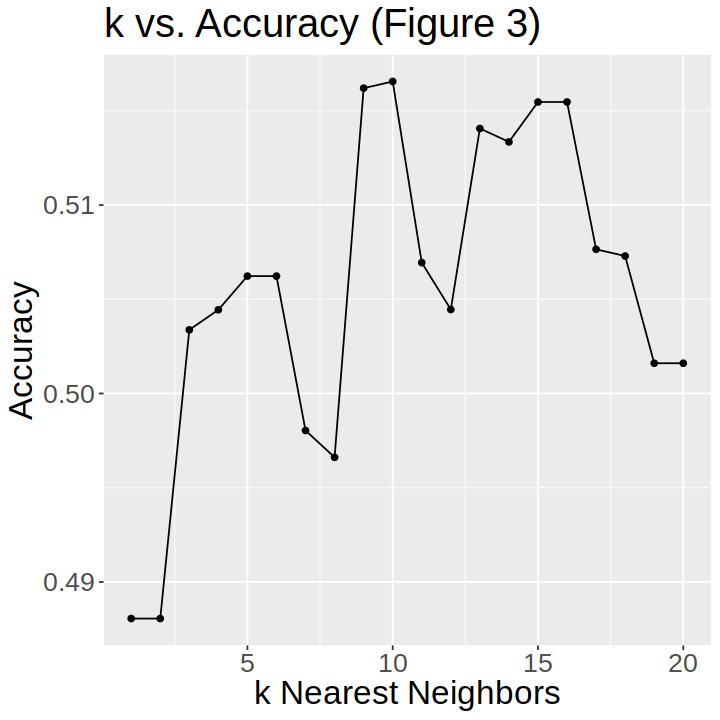

In [24]:
options(repr.plot.width = 6, repr.plot.height = 6)

stroke_accuracies <- stroke_workflow |>
                        filter(.metric == "accuracy") 
                        
cross_val_plot <- ggplot(stroke_accuracies, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                  labs(title = "k vs. Accuracy (Figure 3)",
                       x = "k Nearest Neighbors",
                       y = "Accuracy") +
                  theme(text = element_text(size = 20))
cross_val_plot

**Figure 3**

Based on the above scatter plot, the optimal value was found to be **k = 10** which gave an approximate accuracy of **51.4%**. This k value is optimal since it yields the highest accuracy.

### Step 4. Building The Classification Model

Following our model, we built a new model with our optimal k value (10), fit the data into the original training set, created a prediction using the original testing set, and then set up our confusion matrix. *elaborate on confusion matrix and accuracy*

In [15]:
stroke_spec_matrix <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
            set_engine("kknn") |>
            set_mode("classification")

stroke_recipe <- recipe(diagnosis_group ~ age + stress_levels, data = stroke_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

stroke_fit <- workflow() |>
            add_recipe(stroke_recipe) |>
            add_model(stroke_spec_matrix) |>
            fit(data = stroke_training)

### Step 5. Evaluating The Performance

**Table 3**

The table below displays the accuracy of our model's graph which is ~51.4 %! This is close as upon observing the graph, the point at which our optimal k value gives the highest accuracy is indeed k = 10 at 51.4%.

In [16]:
# We created a table that shows the accuracy

stroke_predictions <- predict(stroke_fit, stroke_testing) |>
                        bind_cols(stroke_testing)

stroke_metrics <- stroke_predictions |>
                        metrics(truth = diagnosis_group, estimate = .pred_class) |>
                        filter(.metric == "accuracy")
stroke_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5139888


In [30]:
# We converted .pred_class into a factor to put into the confusion matrix

stroke_predictions <- stroke_predictions |>
            mutate(.pred_class = fct_recode(.pred_class, "0" = "No Stroke", "1" = "Stroke"))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `.pred_class = fct_recode(.pred_class, `0` = "No Stroke", `1` =
  "Stroke")`.
Caused by warning:
! Unknown levels in `f`: No Stroke, Stroke”


In [18]:
stroke_conf_mat <- stroke_predictions |>
                conf_mat(truth = diagnosis_group, estimate = .pred_class)
stroke_conf_mat

          Truth
Prediction   0   1
         0 294 287
         1 321 349

In [19]:
# Now, we can perform calculations to find our accuracy, precision, and recall values.

accuracy <- (294 + 349)/(294 + 287 + 321 + 349) * 100
accuracy

precision <- 294/(294 + 287) * 100
precision

recall <- 294/(294 + 321) * 100
recall

[1] 51.39888

[1] 50.60241

[1] 47.80488

**Table 4**

The confusion matrix is a tabular representation of our classification models performance. The '0' symbolizes 'No Stroke' and '1' symbolizes 'Stroke'. To calculate accuracy, we take the total number of correct predictions (294 + 349) and divide it by the total number of predictions. To calculate precision, we take the total number of correct positive predictions and divide it by the total number of positive predictions. To calculate recall, we take the total number of correct positive predictions and divide it by the total number of positive test set predictions.

Let's take a deeper dive at each individual value. 294 represents a true positive. This means that a 'no stroke' observation was classified/predicted as 'no stroke'.

287 represents a false positive. This means that a 'stroke' observation was actually classified as a 'no stroke'

321 represents a false negative. This means that a 'no stroke' observation was actually classified as a 'stroke'

And 349 represents a true negative. This means that a 'stroke' observation was actually classified as a 'stroke'

Overall, the accuracy, precision, and recall are approximately 50%. The reasoning for this will be discussed later on.

### Step 5. Visualization of Results

Finally, we create a visualization of our results. The scatter plot on top represents the predicted values that were predicted and the scatter plot beneath represents the actual/tested values. The plots and points have been separated for easier visualization.

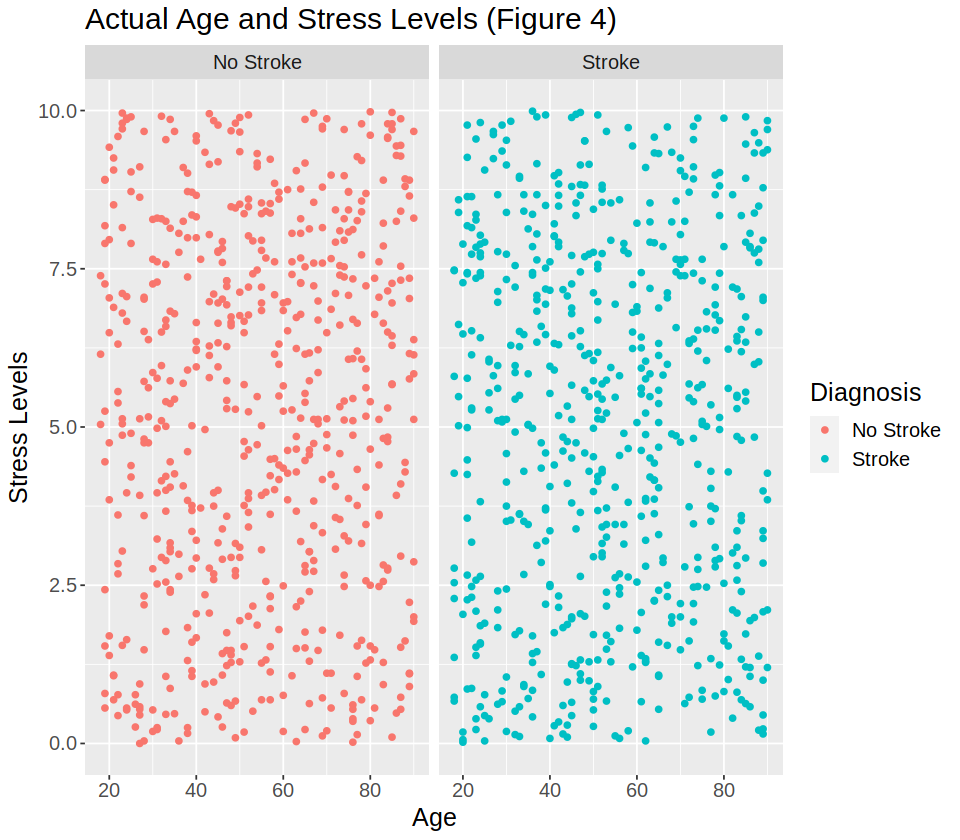

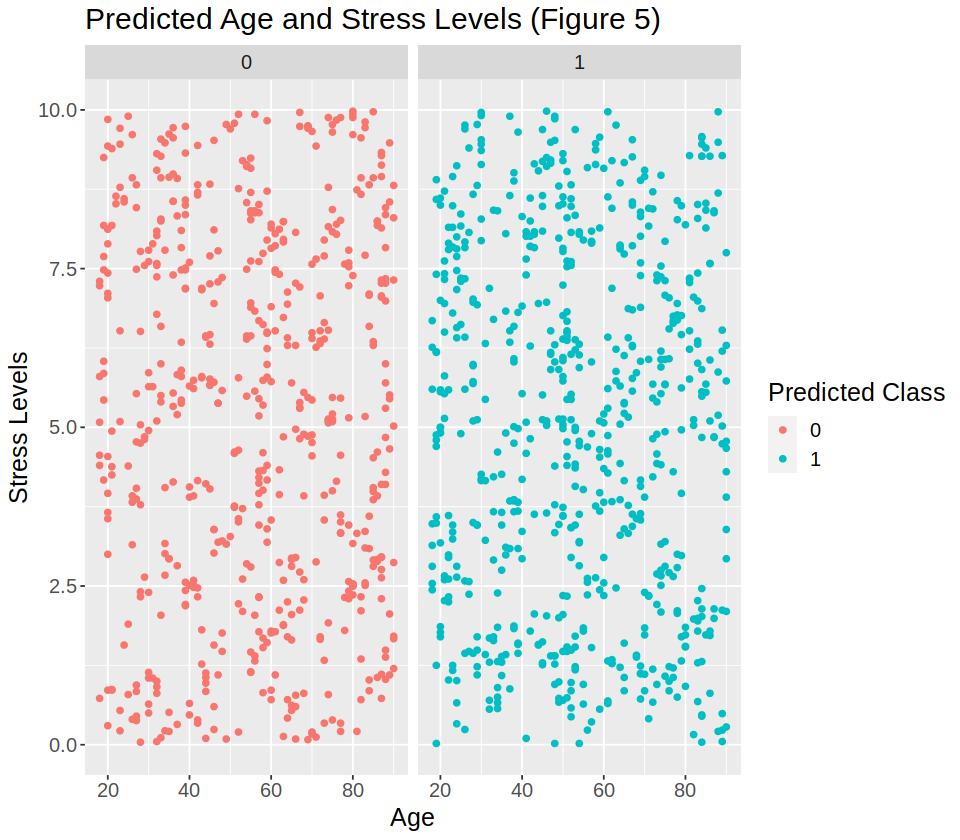

In [23]:
options(repr.plot.width = 8, repr.plot.height = 7)

stroke_plot_1 <- ggplot(stroke_testing, aes(x = age, y = stress_levels, color = diagnosis)) +
                    geom_point() +
                labs(x = "Age",
                     y = "Stress Levels",
                     color = "Diagnosis",
                     title = "Actual Age and Stress Levels (Figure 4)") +
                theme(text = element_text(size = 15)) +
                facet_grid(~ diagnosis)
stroke_plot_2 <- ggplot(stroke_predictions, aes(x = age, y = stress_levels, color = .pred_class)) +
                    geom_point() +
                labs(x = "Age",
                     y = "Stress Levels",
                     color = "Predicted Class",
                     title = "Predicted Age and Stress Levels (Figure 5)") +
                theme(text = element_text(size = 15)) +
                facet_grid(~ .pred_class)

stroke_plot_1
stroke_plot_2

After thoroughly comparing the two scatter plots, we can sort of see that there are less red points and more blue points in the predicted plots as compared to the actual/tested plot. This means that the classifier predicted more values as 'stroke' than 'no stroke.' In short, this aligns with our research questions, which will be further elaborated on.

## 3. Discussion and Conclusion

#### Summary

With our data analysis complete, we can now interpret our tables and graphs and attempt to answer our research question. 

Upon looking at all of the tables, plots, and confusion matrix, the results were not what we expected. Originally, we anticipated that the older you are and the higher your stress levels are, the higher the chances you would have of being diagnosed with stroke. 

Let's start with the results visualization (Step 5.) Upon examination for the actual and predicted plots, the points are evenly dispersed all over the plot. Figure 4 (Actual) shows a fairly even 50/50 split between age and stress levels for stroke diagnosis. If we take a careful inspection at Figure 5(Predicted), it looks like there are less red points (No Stroke) and more blue points (Stroke). That would mean that our model predicted more 'Stroke' then 'No Stroke.' With this, we could say that this answers our research question. However, with an accuracy, precision, and recall of 50%, we cannot be certain of making that claim. 

Looking at Figure 3 (k vs. Accuracy plot), we can see that the line greatly **fluctuates** from *1* to *20*. This means that our predictors aren't stable and that our model cannot make an accurate classification. For example, let's say at *k = 7* (low accuracy), our model classifies more 'No Stroke' than 'Stroke.' Then as we increase our *k* to *10*, our model classifies more *'Stroke'* than *'No Stroke'*. This is a result of having poor/insufficient predictors which causes our results visualization to have **evenly dispersed** points all over. The k value is too sensitive to the data around it. Putting all this aside and analyzing the plot, we can say that our optimal k value is *10* with a *~51.4%* accuracy. An accuracy of this value means that our model is not very effective. We can support this statement by saying that our choice or number of predictors were not the best choice. This means that stroke diagnosis does not solely rely on age and stress levels and relies on a bunch of other factors. If we included more factors/predictors from the original data set, we could have increased our accuracy. However, we should also be aware that some predictors may have no effect on the accuracy. 

The confusion matrix (Table 4) further strengthens the preposition that our predictors were insufficient/poor, as we calculated a 51.4% accuracy, 50% precision, and 47.8% recall. All of these values are ~50%, meaning that accuracy is 50%, ~50% of the numbers are reproducible, ~50% of the positive observations (from the test set) are actually positive (meaning that our model has a ~50% effectiveness). Thus, age and stress as predictors alone will not suffice in obtaining a higher accuracy, recall, and recall. 

Overall, the results were not what we expected. This is a result of poor/insufficient predictors which resulted in a 50/50 Stroke/No Stroke plot where the k nearest neighbor algorithm had a 50% of classifying as stroke or no stroke.

#### Future Impact

As a result of these findings, this could have an impact on how we perceive stroke diagnosis. We now know that stroke diagnosis depends on a multitude of factors and does not solely rely on age and stress. However, this does not mean that we should neglect age and stress. Age and stress are broad categories that subdivide into further interrelated categories. For example, as you get older, your physical and/or mental health starts to decline. You start to live on your own or get married. Your weight and physical activity levels may change. You may start to feel more stressed as you tackle more responsibilities as an adult which can lead to increased blood pressure and change in diet (which then further leads to the amount of nutrients you have in your body!). Ultimately, we can say that age and stress levels branch off of each other and into more categories that depend on each other. Being diagnosed with stroke will solely depend on the quality of your life.

#### Future Questions

Looking into the future, we wander more about what factors significantly contribute to an individual's stroke diagnosis. For example, now that we know that age and stress levels branch off into several different categories, we may begin to wonder: What kinds of food will significantly increase your chances of stroke? Does your job, house, and relationship life significantly contribute to stroke diagnosis? Is stroke a genetic problem that can be passed down from previous generations of family? Professional hands-on research and further scientific endeavors are required in order to answer such questions.

## 4. References

Venugopal, U., & Agur, A. (n.d.). Stroke Prediction. Kaggle. Retrieved from 
https://www.kaggle.com/datasets/teamincribo/stroke-prediction/data

Dehkharghani, S. (2021). Stroke. Exon Publications. https://doi.org/10.36255/exonpublications.stroke.2021
